<a href="https://colab.research.google.com/github/kdemertzis/ML_BigData_CyberSecurity-test/blob/master/Captcha/Captcha%20Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
tf.__version__

'2.7.0'

In [4]:
!git clone https://github.com/kdemertzis/ML_BigData_CyberSecurity-test.git

Cloning into 'ML_BigData_CyberSecurity-test'...
remote: Enumerating objects: 12338, done.
remote: Counting objects: 100% (12338/12338), done.
remote: Compressing objects: 100% (4918/4918), done.
remote: Total 12338 (delta 7349), reused 12270 (delta 7314), pack-reused 0
Receiving objects: 100% (12338/12338), 368.32 MiB | 23.40 MiB/s, done.
Resolving deltas: 100% (7349/7349), done.
Checking out files: 100% (12168/12168), done.


In [6]:
# Path to the data directory
data_dir = Path("/content/ML_BigData_CyberSecurity-test/Captcha/captcha_images_v2")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png"))))) #data_dir.glob outputs posixpath (ref above) mapped to str
print(images[:33])

labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
print(labels[:33])

characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])
print("Max Length within labels ",max_length)

['/content/ML_BigData_CyberSecurity-test/Captcha/captcha_images_v2/226md.png', '/content/ML_BigData_CyberSecurity-test/Captcha/captcha_images_v2/22d5n.png', '/content/ML_BigData_CyberSecurity-test/Captcha/captcha_images_v2/2356g.png', '/content/ML_BigData_CyberSecurity-test/Captcha/captcha_images_v2/23mdg.png', '/content/ML_BigData_CyberSecurity-test/Captcha/captcha_images_v2/23n88.png', '/content/ML_BigData_CyberSecurity-test/Captcha/captcha_images_v2/243mm.png', '/content/ML_BigData_CyberSecurity-test/Captcha/captcha_images_v2/244e2.png', '/content/ML_BigData_CyberSecurity-test/Captcha/captcha_images_v2/245y5.png', '/content/ML_BigData_CyberSecurity-test/Captcha/captcha_images_v2/24f6w.png', '/content/ML_BigData_CyberSecurity-test/Captcha/captcha_images_v2/24pew.png', '/content/ML_BigData_CyberSecurity-test/Captcha/captcha_images_v2/25257.png', '/content/ML_BigData_CyberSecurity-test/Captcha/captcha_images_v2/253dc.png', '/content/ML_BigData_CyberSecurity-test/Captcha/captcha_images_

In [7]:
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'2', '6', 'x', 'b', 'y', '7', 'n', 'd', 'g', 'w', '3', '4', 'p', 'e', 'c', '5', 'f', '8', 'm'}


In [8]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)

    train_samples = int(size * train_size)
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

##Create Dataset Objects

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)) 
#encoding each image sample with map function
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [10]:
train_dataset.take(1)

<TakeDataset shapes: {image: (None, 200, 50, 1), label: (None, None)}, types: {image: tf.float32, label: tf.int64}>

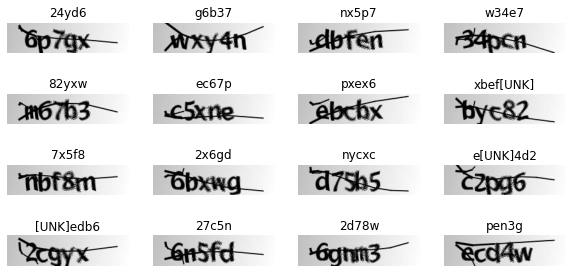

In [11]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1): #one batch of samples (here, 16)
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [12]:
class CTCLayer(layers.Layer):  # inheriting as subclass of the keras layers class
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):  # call is the default method to invoke on call to the layer
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(   # layers is from tensorflow.keras
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    
    new_shape = ((img_width // 4), (img_height // 4) * 64)  # dimension of feature map from CNN reduced accross the width
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x) # +1 in output nodes is for the blank character used in CTC Loss

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

In [13]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
59/59 [==============================] - 46s 131ms/step - loss: 20.8416 - val_loss: 16.4159
Epoch 2/100
59/59 [==============================] - 6s 94ms/step - loss: 16.3279 - val_loss: 16.4357
Epoch 3/100
59/59 [==============================] - 6s 94ms/step - loss: 16.3294 - val_loss: 16.4375
Epoch 4/100
59/59 [==============================] - 6s 95ms/step - loss: 16.3226 - val_loss: 16.4333
Epoch 5/100
59/59 [==============================] - 6s 95ms/step - loss: 16.3179 - val_loss: 16.4087
Epoch 6/100
59/59 [==============================] - 6s 94ms/step - loss: 16.3110 - val_loss: 16.3700
Epoch 7/100
59/59 [==============================] - 6s 95ms/step - loss: 16.2870 - val_loss: 16.3051
Epoch 8/100
59/59 [==============================] - 6s 96ms/step - loss: 16.2572 - val_loss: 16.2521
Epoch 9/100
59/59 [==============================] - 6s 96ms/step - loss: 16.2215 - val_loss: 16.1821
Epoch 10/100
59/59 [==============================] - 6s 96ms/step - loss: 16.15

In [14]:
model.save('captcha_model.h5')

## Inference

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

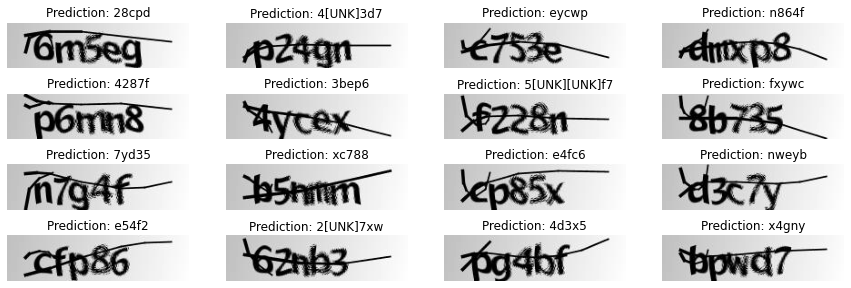

In [15]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    print(pred, pred.shape)
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        print(res)
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        print("Decoded from CTC ",res)
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()